
✅ Predicted vs Actual MVPs (2019–2022):
   season          predicted_mvp  predicted_share             actual_mvp  \
0    2019  Giannis Antetokounmpo         0.725263  Giannis Antetokounmpo   
1    2020  Giannis Antetokounmpo         0.722627  Giannis Antetokounmpo   
2    2021           Nikola Jokic         0.590204           Nikola Jokic   
3    2022  Giannis Antetokounmpo         0.502551           Nikola Jokic   

   actual_share  
0         0.932  
1         0.952  
2         0.961  
3         0.875  

✅ Model Performance (2019–2022 test set)
MSE: 0.0008
R² : 0.7391


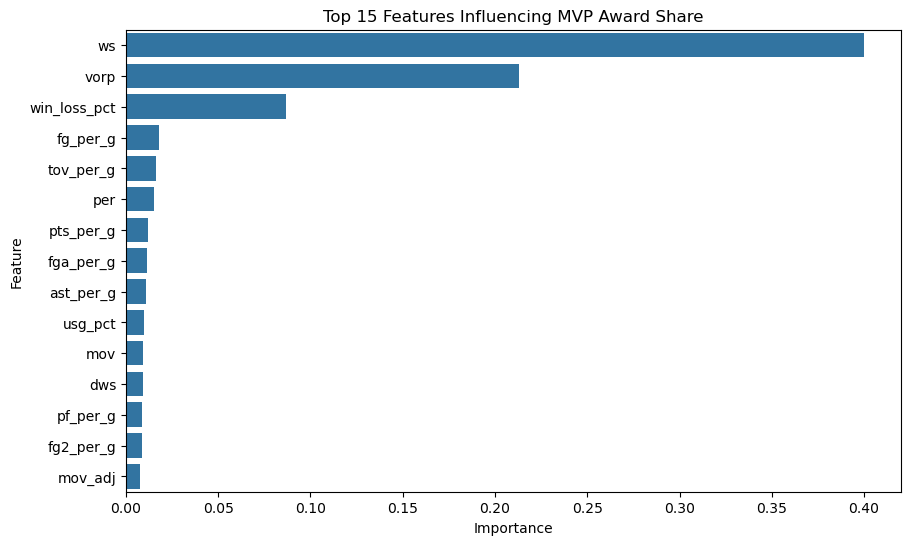

In [9]:
# train_test_mvp_model.py

import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode

# =======================
# 1. Load Dataset
# =======================

df = pd.read_csv("NBA_Dataset.csv")

# Clean player names (remove accents)
df["player"] = df["player"].apply(lambda x: unidecode.unidecode(str(x)))

# Ensure 'season' is integer (e.g., 1982, 1983, ...)
df["season"] = df["season"].astype(int)

# =======================
# 2. Feature Engineering
# =======================

# Simplify positions (G/F/C)
df["pos"] = df["pos"].replace({
    "PG": "G",
    "SG": "G",
    "SF": "F",
    "PF": "F",
    "C": "C"
})

# One-hot encode positions
df = pd.get_dummies(df, columns=["pos"], prefix="pos")

# Add numeric year feature
df["season_num"] = df["season"]

# Award share column already present in dataset
target = "award_share"

# Drop identifiers (not predictive features)
drop_cols = ["player", "team_id", "Pos", "season"]

feature_cols = [c for c in df.columns if c not in drop_cols + [target]]

# =======================
# 3. Normalize Per Season
# =======================

def normalize_season(group):
    return (group - group.mean()) / group.std(ddof=0)

df[feature_cols] = df.groupby("season")[feature_cols].transform(normalize_season)

# =======================
# 4. Train/Test Split
# =======================

train = df[df["season"] <= 2018].copy()
test = df[(df["season"] >= 2019) & (df["season"] <= 2022)].copy()

X_train, y_train = train[feature_cols], train[target]
X_test, y_test = test[feature_cols], test[target]

# =======================
# 5. Train Model
# =======================

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Save model + features
joblib.dump(model, "mvp_model.pkl")
joblib.dump(feature_cols, "feature_cols.pkl")

# =======================
# 6. Evaluate
# =======================

y_pred = model.predict(X_test)

# =======================
# 6b. Top Predicted vs Actual MVPs per Season
# =======================

predictions_df = test[["player", "season"]].copy()
predictions_df["predicted_award_share"] = y_pred
predictions_df["actual_award_share"] = y_test.values

mvp_comparison = []

for season in range(2019, 2023):
    season_df = predictions_df[predictions_df["season"] == season]

    # Predicted MVP
    pred_mvp = season_df.loc[season_df["predicted_award_share"].idxmax()]

    # Actual MVP
    actual_mvp = season_df.loc[season_df["actual_award_share"].idxmax()]

    mvp_comparison.append({
        "season": season,
        "predicted_mvp": pred_mvp["player"],
        "predicted_share": pred_mvp["predicted_award_share"],
        "actual_mvp": actual_mvp["player"],
        "actual_share": actual_mvp["actual_award_share"]
    })

mvp_comparison_df = pd.DataFrame(mvp_comparison)

print("\n✅ Predicted vs Actual MVPs (2019–2022):")
print(mvp_comparison_df)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Model Performance (2019–2022 test set)")
print(f"MSE: {mse:.4f}")
print(f"R² : {r2:.4f}")

# =======================
# 7. Feature Importance
# =======================

importances = pd.Series(model.feature_importances_, index=feature_cols)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Features Influencing MVP Award Share")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
